In [1]:
import numpy as np
from pathlib import Path
import cv2
import pandas as pd
from skimage import measure, filters, draw
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tqdm 
from scipy import ndimage

import SimpleITK as sitk
import itkwidgets 
import napari
import copy

from napari.utils.colormaps import colormap_utils as cu

c:\Users\zoeba\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# previous_area=500
# enchainement_T_F_area=[] #true if the next is smaller
# previous_ML=100
# enchainement_major_length=[] #true if the next is smaller
# for im_in in mask1[-1:]:
#     im_floodfill = im_in.copy()
#     h, w = im_in.shape[:2]
#     mask_new = np.zeros((h+2, w+2), np.uint8)
#     cv2.floodFill(im_floodfill, mask_new, (0,0), 0)
    
#     sum_im_in=np.sum(im_floodfill)
#     if sum_im_in < previous_area:
#         enchainement_T_F_area.append(True)
#     else: 
#         enchainement_T_F_area.append(False)
#     previous_area=sum_im_in
    
#     properties_to_test=["axis_major_length"] 
#     props = measure.regionprops_table(im_floodfill, im_in, properties=properties_to_test)
#     major_Lenght=(props["axis_major_length"][0])

#     if major_Lenght < previous_ML:
#         enchainement_major_length.append(True)
#     else: 
#         enchainement_major_length.append(False)
#     previous_ML=major_Lenght
        
#     fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(15,6))
#     ax[0].imshow(im_in[270:310, 220:300])
#     ax[1].imshow(im_floodfill[270:310, 220:300])
#     plt.show()
# import collections
# frequency = collections.Counter(enchainement_T_F_area)
# print(frequency)
# frequency2 = collections.Counter(enchainement_major_length)
# print(frequency2)

In [3]:
def fit_ellipses(mask, rangemin, rangemax):
    ''' 
    Le but est de récuperer les paramètres d'une liste ellipse en fonction d'une liste de masques fournis par le network construction
    Args :
        mask (numpy array) : masque des artères
        rangemin (int): début des coupes sélectionnées
        rangemax (int): fin des coupes sélectionnées
    Return:
        list_params_ellispses (list[list[double]]): paramètres de chaque ellipse
    '''
    list_params_ellipses=[]
    for img in tqdm.tqdm(mask[rangemin:rangemax]):
        list_points_ellipse=[]
        for j in range(img.shape[0]):
            for i in range(img.shape[1]):
                if img[j][i] == 0:
                    list_points_ellipse.append((i,j))
        array_points_ellipse=np.array(list_points_ellipse)
        ell = measure.EllipseModel()
        ell.estimate(array_points_ellipse)
        list_params_ellipses.append(ell.params)
    return list_params_ellipses

In [4]:
def create_3d_ellipses(list_params_ellipses):
    '''
    Crée le numpy array représentant les images des ellipses
    Args:
        list_params_ellispses (list[list[double]]): paramètres de chaque ellipse
    Return:
        ellipses_3d (numpy array) : 3d images of the ellipses
    '''
    list_2D_ellipses = []
    for params in list_params_ellipses:
        xc, yc, a, b, theta = params
        t = np.linspace(0, 2*np.pi, 100)
        X = xc + a*np.cos(theta)*np.cos(t) - b*np.sin(theta)*np.sin(t)
        Y = yc + a*np.sin(theta)*np.cos(t) + b*np.cos(theta)*np.sin(t)
        built_ellipse = np.zeros((512,512))
        for i in range(len(X)):
            built_ellipse[int(Y[i])][int(X[i])] = 1

        list_2D_ellipses.append(built_ellipse)
    ellipses_3D = np.array(list_2D_ellipses)
    return ellipses_3D

In [5]:
def ensuring_3d_continuity(original_list_params, seuil):
    ''' 
    Vérification itérative qu'aucune ellipse est abberante et modification si c'est le cas
    Args:
        original_list_params (list[list[double]]): paramètres originaux de chaque ellipse
        seuil (list[int]): valeurs d'écarts autorisés entre l'ellipse précédente et l'ellipse actuelle
    Return:
        homogeneous_list_params (list[list[double]]): liste des paramètres des ellipses après modification
    '''
    count = 0 #compter le nombre de modifications

    homogeneous_list_params = copy.deepcopy(original_list_params)

    for i in range(len(homogeneous_list_params)-1,0,-1): # pour toutes les ellipses en commençant par le haut
        for j in range(len(homogeneous_list_params[0])): # pour chacun des paramètres
            param_avant = homogeneous_list_params[i][j]
            param = homogeneous_list_params[i-1][j]
            if j!= 0 and j!=1: # différenciation de condition de modification selon le type de paramètre
                if np.abs(param-param_avant*100/param_avant) > seuil[j]: # taux de variation (pour a, b et theta)
                    count +=1
                    if (param-param_avant<0): #si l'ellipse est plus petite que l'ellipse d'avant
                        homogeneous_list_params[i-1][j] = param_avant-param*10/100
                    else: #si l'ellipse est plus grande que l'ellipse d'avant
                        homogeneous_list_params[i-1][j] = param_avant+param*10/100
            else:
                if np.abs(param_avant-param) > seuil[j]: # écart en nombre de pixels (pour xc et yc)
                    count +=1
                    homogeneous_list_params[i-1][j] = param_avant

    #print(count)
    return homogeneous_list_params

In [6]:
def smooth_3d_ellipses(homogeneous_list_params, nb_slices, ponderation):
    '''
    Lissage de la surface des ellipses
    Args:
        homogeneous_list_params (list[list[double]]): liste des paramètres des ellipses 
        nb_slices (int): nombre de coupes à prendre en compte pour le lissage
        ponderation (list[int]): ponderation associée à chaque coupe
    Return:
        smooth_list_params (list[list[double]]): liste des paramètres des ellipses après lissage
    '''
    smooth_list_params = copy.deepcopy(homogeneous_list_params)

    for i in range(len(homogeneous_list_params)-(nb_slices+1)):
        for j in range(len(homogeneous_list_params[0])):
            nearby_params = []
            for k in range(nb_slices):
                nearby_params.append(homogeneous_list_params[i+k][j])
            smooth_list_params[i+nb_slices//2+1][j] = np.sum(list(np.multiply(nearby_params,ponderation))/np.sum(ponderation))
    return smooth_list_params

In [7]:
def find_slice_with_mask(mask):
    '''
    Détecte sur les index des premières et dernière tranches d'un masque. 
    Args:
        mask (np array): le masque ou le fond est des 1 et le masque des 0
    Return:
        (rangemin,rangemax) (int,int): tuple avec l'index des premières et dernière tranches d'un masque. 
    '''
    nb_slices_with_masks=[]
    for nb_slice in range(mask.shape[0]-1, 0,-1):
        if 0 in mask[nb_slice]:
            nb_slices_with_masks.append(nb_slice)
    rangemin = np.min(nb_slices_with_masks) #mask 1
    rangemax = np.max(nb_slices_with_masks) #mask 1
    return (rangemin,rangemax)

In [8]:
def construct_ellipses_network(mask_list,range_to_do):
    '''
    En partant de la liste de masques construite par la network construction, des ellipses sont approximées pour reconstruire un réseau artériel lisse. 
    Args:
        mask_list (list[np.array]): la liste des masque construite par la network construction
    Return:
        info_all_masks (list[dic]): une liste où pour chaque loigne (qui correspond à un masque), il y a un dictionnaire où les clefs sont: rangemin, rangemax, mask,  smooth_ellipses
        ellipses_network (np.array): l'image 3D où le réseau d'ellipse est reconstitué
    ''' 
    info_all_masks = []
    ellipses_network=np.zeros(mask_list[0].shape)
    for index_mask in (range(range_to_do)):#len(mask_list))):
        print(index_mask+1, " out of ", range_to_do)
        mask = mask_list[index_mask]
        mask = np.where(mask == 255, 0, 1)
        rangemin,rangemax=find_slice_with_mask(mask)

        list_params = fit_ellipses(mask, rangemin, rangemax)
        
        seuil = [7, 7, 60, 60, 300]
        ponderation = [1,2,3,4,4,4,3,2,1]
        nb_slices = 9

        homogeneous_params = ensuring_3d_continuity(list_params, seuil)
        smooth_params = smooth_3d_ellipses(homogeneous_params, nb_slices, ponderation)
        smooth_ellipses = create_3d_ellipses(smooth_params)

        before=np.zeros((rangemin, mask.shape[1],mask.shape[1]))
        after=np.zeros((mask.shape[0]-rangemax, mask.shape[1],mask.shape[1]))
        whole=np.concatenate((before,smooth_ellipses,after))
        ellipses_network=ellipses_network+whole

        info_of_one_mask={'index':index_mask, 'rangemin':rangemin,'rangemax':rangemax,'mask':mask, 'smooth_ellipses':smooth_ellipses}
        info_all_masks.append(info_of_one_mask)
    return info_all_masks, ellipses_network

In [9]:
def filling_ellipses(ellipses):
    #avec fill binary holes
    '''
    En partant  des images 3D des ellipses, on crée une image 3D des ellipses remplies. 
    Args:
        ellipses (np.array): les ellipses à remplir
    Return:
        filled_ellipses_np (np.array): les ellipses remplies
    ''' 
    filled_ellipses=[]
    for index in range(len(ellipses)):
        ellipse=copy.deepcopy(ellipses[index])
        ellipse_filled=ndimage.binary_fill_holes(ellipse)
        filled_ellipses.append(ellipse_filled)
        filled_ellipses_np=np.array(filled_ellipses)
    return filled_ellipses_np

In [10]:
def ploting_hist_from_ellipse(filled_ellipses, image):
    #avec fill binary holes
    '''
    En partant  des images 3D des ellipses, on crée une image 3D des ellipses remplies. 
    Args:
        ellipses (np.array): les ellipses à remplir
    Return:
        filled_ellipses_np (np.array): les ellipses remplies
    ''' 
    for index in range(len(filled_ellipses)):
        slice_ell=filled_ellipses[index]
        slice_im=image[index]
        slice_im=np.where(slice_ell==1,slice_im, 0)
        plt.hist(slice_im.flatten(), bins=255)
        plt.show()

In [11]:
mask_list = np.load(Path("temp/mask_list.npy"))

index_mask=3
mask1 = mask_list[index_mask]
mask1 = np.where(mask1 == 255, 0, 1)

rangemin,rangemax =find_slice_with_mask(mask1)

list_params = fit_ellipses(mask1, rangemin,rangemax)
ellipses_3d = create_3d_ellipses(list_params)

seuil = [7, 7, 60, 60, 300]
ponderation = [1,2,3,4,4,4,3,2,1]
nb_slices = 9

homogeneous_params = ensuring_3d_continuity(list_params, seuil)
smooth_params = smooth_3d_ellipses(homogeneous_params, nb_slices, ponderation)

 91%|█████████▏| 21/23 [00:02<00:00,  8.56it/s]

In [ ]:
# create the new ellipses using parameters
homogeneous_ellipses = create_3d_ellipses(homogeneous_params)
smooth_ellipses = create_3d_ellipses(smooth_params)

# look at the result
image_array = np.load(Path("temp/preprocessed_image.npy"))
image_originale=image_array[rangemin:rangemax]
mask1_slice=mask1[rangemin:rangemax]

viewer = napari.Viewer()
image_layer = viewer.add_image(image_originale, colormap="gray")
# image_layer = viewer.add_image(ellipses_3d, colormap='blue',blending="additive")
image_layer = viewer.add_image(smooth_ellipses, colormap='green',blending="additive")
image_layer = viewer.add_image(np.where(mask1_slice==1,0,1), colormap='red',blending="additive")
napari.run()

In [ ]:
filled_ellipses=filling_ellipses(smooth_ellipses)

viewer = napari.Viewer()
image_layer = viewer.add_image(smooth_ellipses, colormap="gray")
image_layer = viewer.add_image(filled_ellipses, colormap="blue", blending="additive")
napari.run()


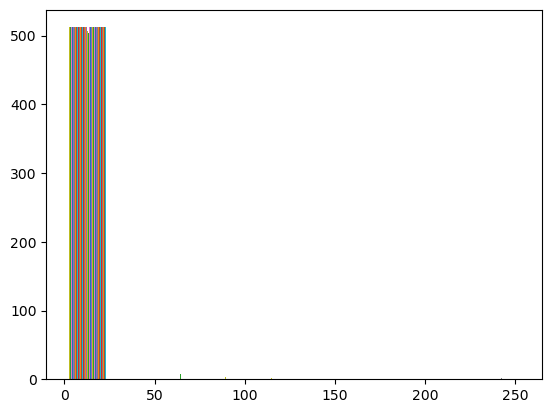

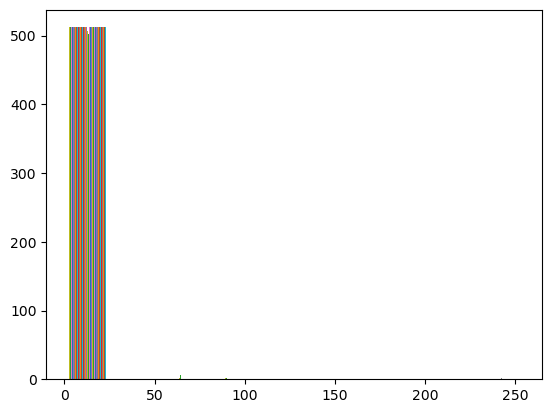

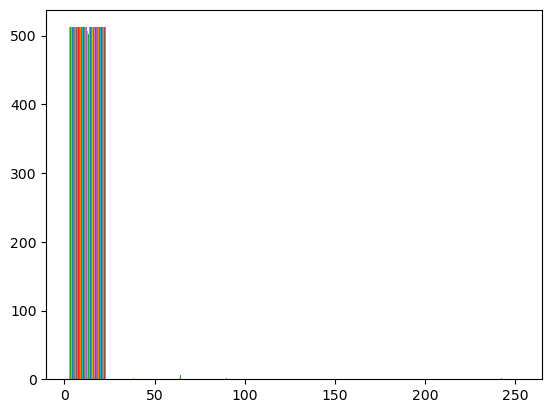

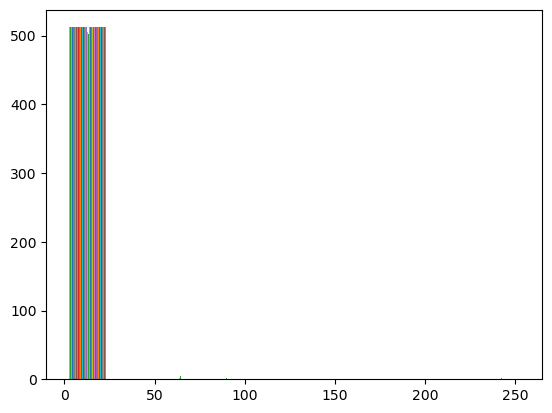

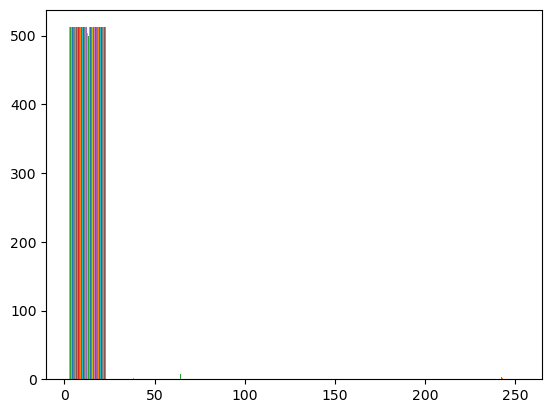

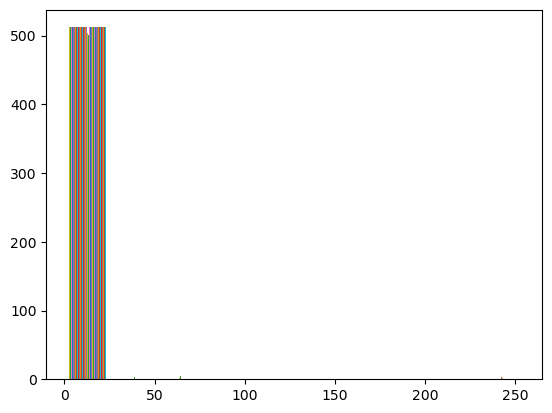

In [ ]:
ploting_hist_from_ellipse(filled_ellipses, image_originale)

# constructing the whole network

In [11]:
# mask_list = np.load(Path("temp/mask_list.npy"))
# range_to_do=4
# info_all_masks, ellipses_network=construct_ellipses_network(mask_list,range_to_do)

1  out of  4


100%|██████████| 265/265 [00:45<00:00,  5.86it/s]


2  out of  4


100%|██████████| 230/230 [00:27<00:00,  8.48it/s]


3  out of  4


100%|██████████| 23/23 [00:05<00:00,  4.58it/s]


4  out of  4


100%|██████████| 23/23 [00:09<00:00,  2.46it/s]


In [ ]:
# viewer = napari.Viewer()
# image_layer = viewer.add_image(ellipses_network, colormap="gray")
# napari.run()

# test filling holes to keep just in case

In [ ]:
# def filling_ellipses(params, ellipses_path):
#     '''
#     En partant d'une liste de paramêtres d'ellipses et des images 3D des ellipses, on crée une image 3D des ellipses remplies. 
#     Args:
#         params (list[list[double]]): la liste des paramêtres des ellipses
#         ellipses (np.array): les ellipses à remplir
#     Return:
#         filled_ellipses_np (np.array): les ellipses remplies
#     ''' 
#     filled_ellipses=[]
#     ellipses=cv2.imread(ellipses_path)#On retire le debug
#     # np_ell=np.load(Path(ellipses_path))
#     print(ellipses)
#     plt.imshow(ellipses)
#     plt.show()
#     for index in range(ellipses.shape[0]):
#         ellipse_filled=copy.deepcopy(ellipses[index])
#         mask_new = np.zeros((ellipse_filled.shape[0]+2,ellipse_filled.shape[0]+2), dtype=np.uint8)
#         cv2.imshow("iamge",mask_new)
#         ellipse_filled=cv2.floodFill(ellipse_filled,  mask_new, (100,100), 1)
#         plt.imshow(mask_new)
#         plt.show()
#         # filled_ellipses.append(ellipse)
#         # filled_ellipses_np=np.array(filled_ellipses)
#     # return filled_ellipses_np

# def filling_ellipses(params, ellipses):
#     #avec fill ellipse
#     '''
#     En partant d'une liste de paramêtres d'ellipses et des images 3D des ellipses, on crée une image 3D des ellipses remplies. 
#     Args:
#         params (list[list[double]]): la liste des paramêtres des ellipses
#         ellipses (np.array): les ellipses à remplir
#     Return:
#         filled_ellipses_np (np.array): les ellipses remplies
#     ''' 
#     filled_ellipses=[]
#     for index in range(len(params)):
#         ellipse_filled=copy.deepcopy(ellipses[index])
#         # params_ell=params[index]
#         # rr, cc = draw.ellipse(r = params_ell[1], c=params_ell[0], r_radius=params_ell[2],c_radius=params_ell[3], rotation=params_ell[4])
#         # ellipse_filled[rr,cc]=1
#         ellipse_filled=ndimage.binary_fill_holes(ellipse_filled)
#         filled_ellipses.append(ellipse_filled)
#         filled_ellipses_np=np.array(filled_ellipses)
#     return filled_ellipses_np
